In [1]:
import pandas as pd
from datetime import datetime, date, timedelta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
index_map = {'^BSESN':'Sensex', 
             '^DJI'  :'Dow Jones', 
             '^FCHI' :'CAC40', 
             '^FTSE' :'FTSE', 
             '^GDAXI':'DAX', 
             '^GSPC' :'SP500',
             '^IXIC' :'Nasdaq', 
             '^NSEI' :'Nifty'}

In [3]:
data = pd.read_csv('datasets/index_ohlcv_10yrs.csv')
adcl = data[['Date', 'index-name', 'Adj Close']]
adcl = adcl.pivot(index='Date', columns='index-name', values='Adj Close')

In [4]:
adcl.columns

Index(['^BSESN', '^DJI', '^FCHI', '^FTSE', '^GDAXI', '^GSPC', '^IXIC',
       '^NSEI'],
      dtype='object', name='index-name')

In [5]:
def sma_strat_metrics(index, short_win, long_win, to_plot=False):
    swin_col = 'sma_' + str(short_win)
    lwin_col = 'sma_' + str(long_win)
    
    df = adcl[[index]].dropna()
    df.columns = ['adj_close']
    df['a_ret'] = (df['adj_close'] / df['adj_close'].shift(1)) - 1
    df[swin_col] = df['adj_close'].rolling(window=short_win).mean()
    df[lwin_col] = df['adj_close'].rolling(window=long_win).mean()
    df = df.dropna()
    df['pos'] = np.where(df[swin_col] > df[lwin_col], 1, (np.where(df[swin_col] < df[lwin_col], -1, np.nan)))
    df['pos'] = df['pos'].shift(1)
    df['net_ret'] = df['pos'] * df['a_ret']
    df = df.dropna()
    mean_ret, std_ret = round(df['net_ret'].mean(),6), round(df['net_ret'].std(), 6)
    sharpe = round((mean_ret/std_ret) * pow(252,0.5), 6)
    
    if to_plot == True:
        fig, axes = plt.subplots(1,3, figsize=(15,4))
        plt.subplots_adjust(wspace=0.2)
        df[['adj_close', swin_col, lwin_col]].plot(grid=True, ax=axes[0], title=index_map[index] + ' Prices', rot=30)
        df['pos'].plot(grid=True, ax=axes[1], title=index_map[index] + ' Positions', rot=30)
        df['net_ret'].plot(grid=True, ax=axes[2], title=index_map[index] + ' Net Returns', rot=30 )
        plt.show()
    
    return mean_ret, std_ret, sharpe

In [6]:
def bb_strat_metrics(index, lag, std, to_plot=False):
    bb = adcl[[index]].dropna()
    bb.columns = ['adj_close']
    bb['a_ret'] = (bb['adj_close'] / bb['adj_close'].shift(1)) - 1
    bb['sma']   = bb['adj_close'].rolling(window=lag).mean()
    bb['std']   = bb['adj_close'].rolling(window=lag).std()
    bb['upper'] = bb['sma'] + bb['std'] * std
    bb['lower'] = bb['sma'] - bb['std'] * std
    
    bb['pos'] = [np.nan] * len(bb)
    #Previous ADJ_CLOSE < Previous Upper and Current ADJ_CLOSE > Current Upper
    bb['pos'] = np.where((bb['adj_close'].shift(1) < bb['upper'].shift(1)) &\
                         (bb['adj_close'] > bb['upper']), 1, bb['pos'])
    
    #Previous ADJ_CLOSE > Previous SMA and Current ADJ_CLOSE < Current SMA and current_pos = 1
    bb['pos'] = np.where((bb['adj_close'].shift(1) > bb['upper'].shift(1)) &\
                         (bb['adj_close'] < bb['upper']) & bb['pos'] == 1, 0, bb['pos'])
    
    #Previous ADJ_CLOSE > Previous Lower and Current ADJ_CLOSE < Current Lower 
    bb['pos'] = np.where((bb['adj_close'].shift(1) > bb['lower'].shift(1)) &\
                         (bb['adj_close'] < bb['lower']), -1, bb['pos'])
    
    #Previous ADJ_CLOSE < Previous SMA and Current ADJ_CLOSE > Previous SMA and current_pos = -1
    bb['pos'] = np.where((bb['adj_close'].shift(1) < bb['lower']) &\
                         (bb['adj_close'] > bb['lower']) & bb['pos'] == -1, 0, bb['pos'])
    
    bb.loc[bb['pos'].isna(), 'pos'] = 0 
    bb['pos'] = bb['pos'].shift(1)
    bb['net_ret'] = bb['pos'] * bb['a_ret']
    bb.to_csv('bb_values.csv', index=False)
    bb = bb.dropna()
    
    mean_ret, std_ret = round(bb['net_ret'].mean(),6), round(bb['net_ret'].std(), 6)
    sharpe = round((mean_ret/std_ret) * pow(252,0.5), 6)
    
    if to_plot == True:
        fig, axes = plt.subplots(1,3, figsize=(15,4))
        plt.subplots_adjust(wspace=0.2)
        bb[['adj_close', 'sma', 'upper', 'lower']].plot(grid=True, ax=axes[0], title=index_map[index] + ' Prices and BB Bands', rot=30)
        bb['pos'].plot(grid=True, ax=axes[1], title=index_map[index] + ' Positions', rot=30)
        bb['net_ret'].plot(grid=True, ax=axes[2], title=index_map[index] + ' Net Returns', rot=30 )
        plt.show()
    
    return mean_ret, std_ret, sharpe

In [7]:
def rsi_strat_metrics(index, lag, upper, lower, to_plot):
    rsi = adcl[[index]].dropna()
    rsi.columns = ['adj_close']
    rsi['a_ret'] = rsi['adj_close'] / rsi['adj_close'].shift(1) - 1
    rsi = rsi.dropna()
    rsi['up'] = np.where(rsi['a_ret'] > 0, rsi['a_ret'], np.nan)
    rsi['down'] = np.where(rsi['a_ret'] < 0, rsi['a_ret'].abs(), np.nan)
    rsi = rsi.fillna(0.0)
    
    rsi['gain'] = [np.nan] * len(rsi)
    rsi['loss'] = [np.nan] * len(rsi)
    
    rsi = rsi.reset_index()
    rsi.loc[lag-1, 'gain'] = rsi.loc[:lag, 'up'].mean()
    rsi.loc[lag-1, 'loss'] = rsi.loc[:lag, 'down'].mean()
    
    for i in range(lag, len(rsi)):
        rsi.loc[i, 'gain'] = (rsi.loc[i-1, 'gain'] * (lag-1) + rsi.loc[i, 'up'])/lag
        rsi.loc[i, 'loss'] = (rsi.loc[i-1, 'loss'] * (lag-1) + rsi.loc[i, 'down'])/lag
    
    rsi['rs'] = rsi['gain'] / rsi['loss']
    rsi['rsi'] = 100 - (100/(1 + rsi['rs']))
    
    rsi = rsi.dropna()
    rsi['pos'] = [np.nan] * len(rsi)
    rsi['pos'] = np.where((rsi['rsi'].shift(1) < upper) & (rsi['rsi'] > upper), 1, rsi['pos'])
    rsi['pos'] = np.where((rsi['rsi'].shift(1) > upper) & (rsi['rsi'] < upper) & (rsi['pos'] == 1), 0, rsi['pos'] )
    rsi['pos'] = np.where((rsi['rsi'].shift(1) > lower) & (rsi['rsi'] < lower), -1, rsi['pos'])
    rsi['pos'] = np.where((rsi['rsi'].shift(1) < lower) & (rsi['rsi'] > lower) & (rsi['pos'] == -1), 0, rsi['pos'] )
    rsi.loc[rsi['pos'].isna(), 'pos'] = 0
    rsi['pos'] = rsi['pos'].shift(1)
    rsi['net_ret'] = rsi['a_ret'] * rsi['pos']
    rsi.to_csv('rsi.csv', index=False)
    
    mean_ret, std_ret = round(rsi['net_ret'].mean(),6), round(rsi['net_ret'].std(), 6)
    sharpe = round((mean_ret/std_ret) * pow(252,0.5), 6)
    
    if to_plot == True:
        rsi = rsi.set_index('Date')
        fig, axes = plt.subplots(1,3, figsize=(15,4))
        plt.subplots_adjust(wspace=0.2)
        rsi[['adj_close', 'rsi']].plot(grid=True, ax=axes[0], title=index_map[index] + ' Prices and RSI Values', rot=30)
        rsi['pos'].plot(grid=True, ax=axes[1], title=index_map[index] + ' Positions', rot=30)
        rsi['net_ret'].plot(grid=True, ax=axes[2], title=index_map[index] + ' Net Returns', rot=30 )
        plt.show()
    
    return mean_ret, std_ret, sharpe

In [8]:
def gen_metrics(adcl, strat_type, args, to_plot, to_print_metrics):
    metrics = pd.DataFrame(columns=['index', 'mean-ret', 'std-ret', 'sharpe'])
    for i, index in enumerate(adcl.columns):
        if strat_type == 'sma':
            mean_ret, std_ret, sharpe = sma_strat_metrics(index, args[0], args[1], to_plot)
        elif strat_type == 'bb_bands':
            mean_ret, std_ret, sharpe = bb_strat_metrics(index, args[0], args[1], to_plot)
        elif strat_type == 'rsi':
            mean_ret, std_ret, sharpe = rsi_strat_metrics(index, args[0], args[1], args[2], to_plot)
        else:
            print("Unknown strat specified")
            return 
            
        metrics.loc[i] = [index_map[index], mean_ret, std_ret, sharpe]
    
        if to_print_metrics == True:
            print("Index Name : {}".format(index_map[index]))
            print("Mean Daily Returns : {}".format(mean_ret))
            print("Std. Dev. Daily Returns : {}".format(std_ret))
            print("Sharpe Ratio : {}".format(sharpe))  
        
    return metrics.set_index('index')

In [9]:
def agg_metrics(adcl, params, strat_type):
    metrics = None
    for param in params:
        m = gen_metrics(adcl, strat_type, param, False, False)
        metrics = pd.concat([metrics, m[['sharpe']]], axis=1)
    
    metrics.columns = [ str(w[0]) + '-' + str(w[1]) for w in params ]
    
    return metrics

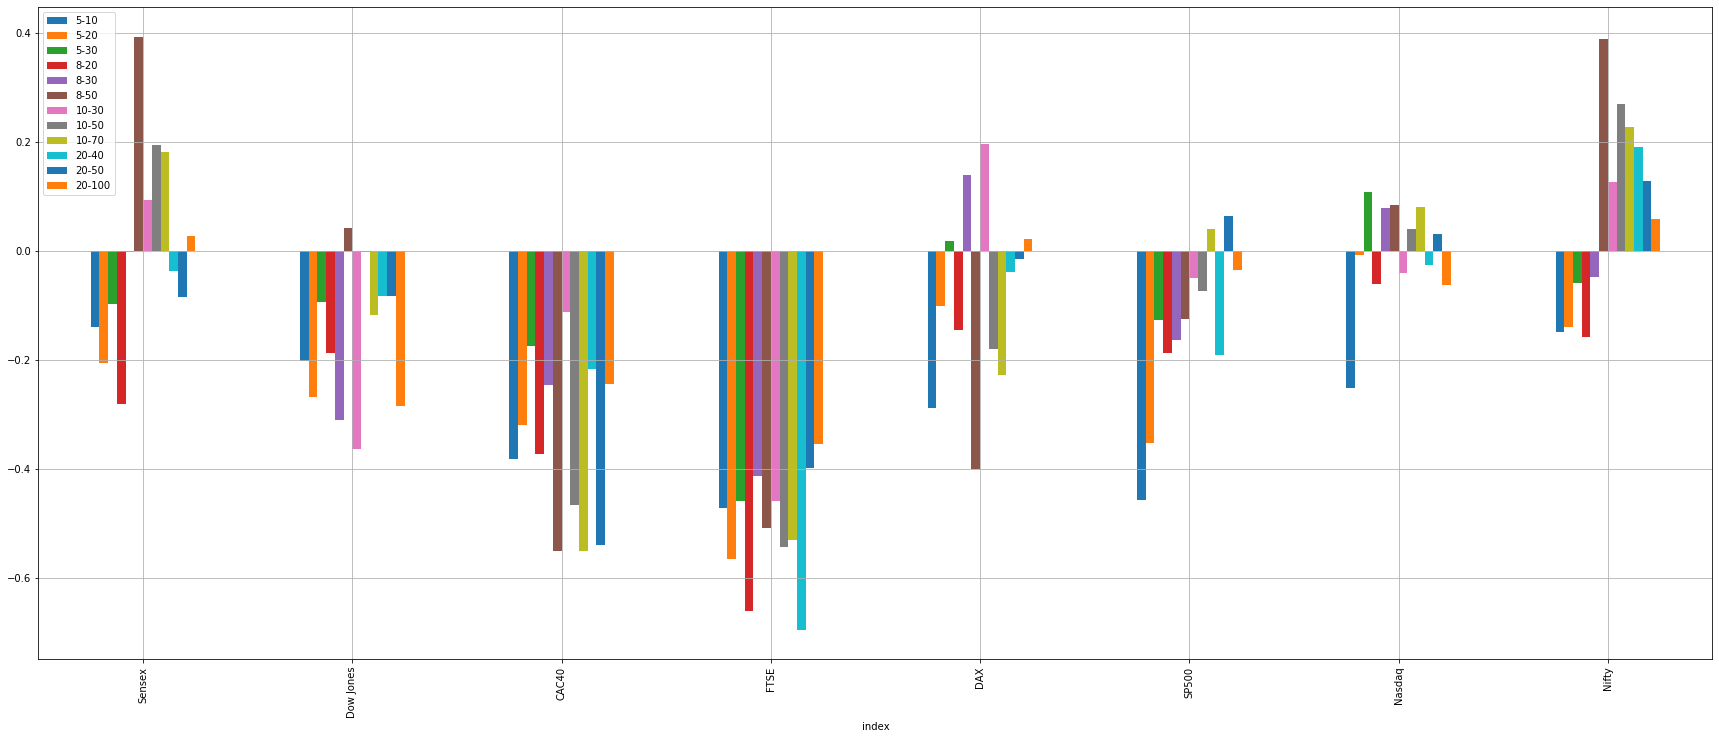

In [10]:
windows = [(5,10), (5,20), (5,30), (8,20), (8,30), (8,50), (10,30), (10,50), (10,70), (20,40), (20,50), (20,100)]
metrics_sma = agg_metrics(adcl, windows, 'sma')
metrics_sma.plot(grid=True, kind='bar', figsize=(30,12))
plt.show()

c:\users\dell.000\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


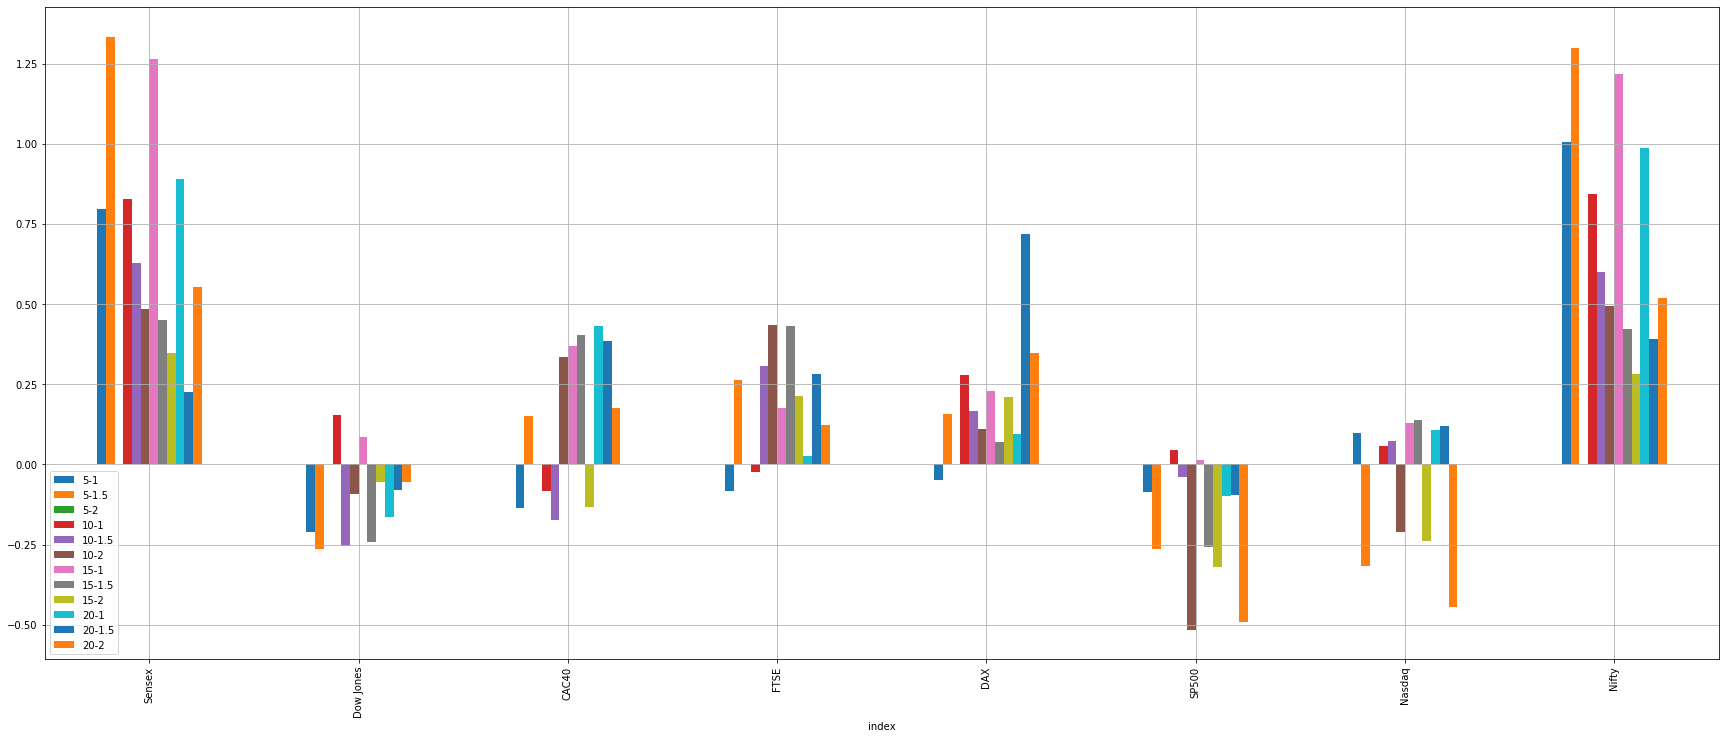

In [11]:
params = [(5,1), (5,1.5), (5,2), (10,1), (10,1.5), (10,2), (15,1),(15, 1.5),(15,2),(20,1),(20,1.5),(20,2)]
metrics_bb = agg_metrics(adcl, params, 'bb_bands')
metrics_bb.plot(grid=True, kind='bar', figsize=(30,12))
plt.show()

c:\users\dell.000\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


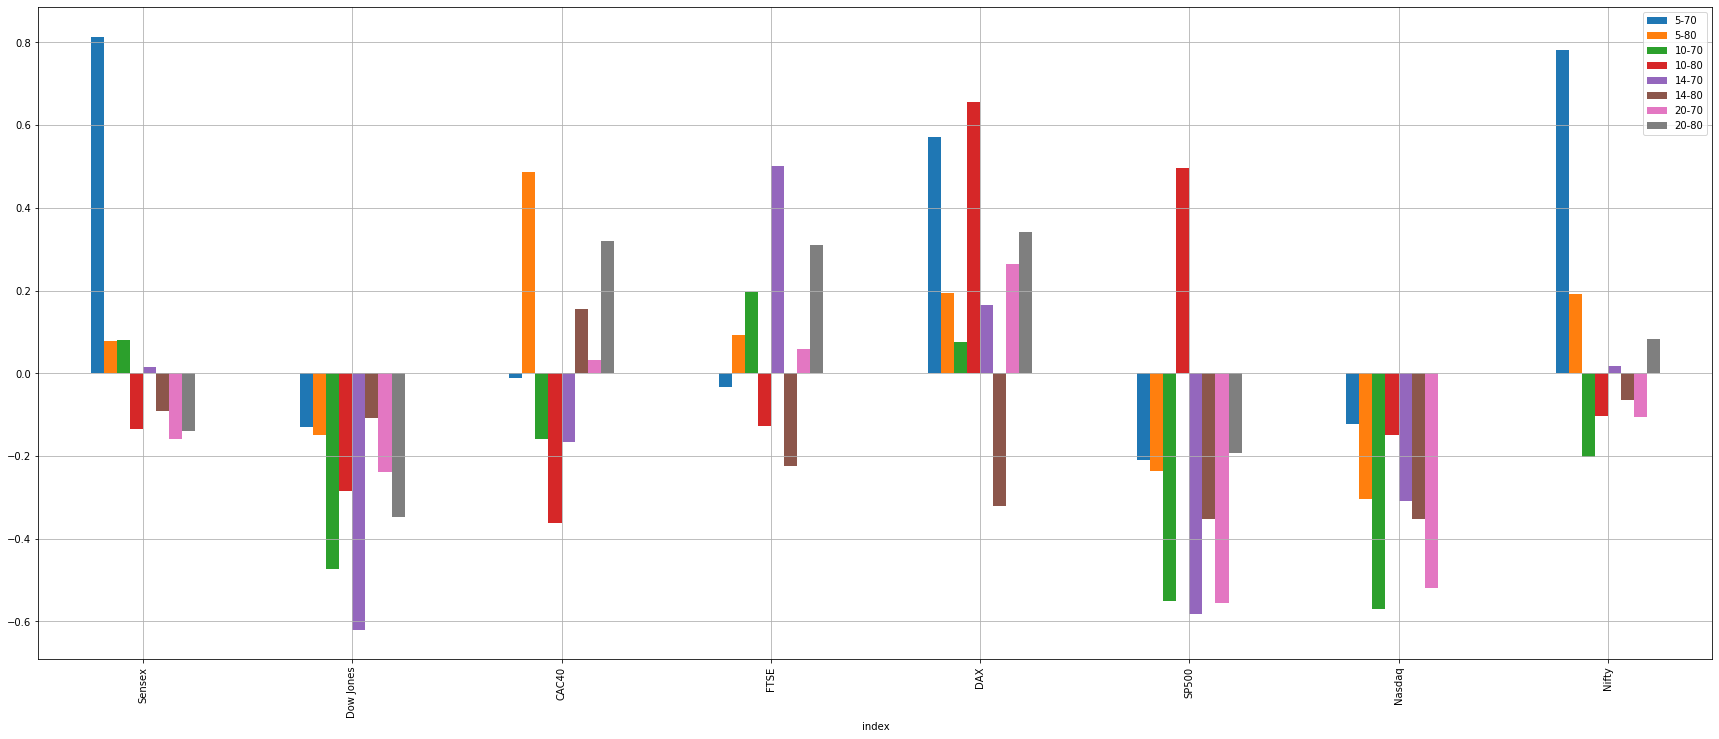

In [12]:
params = [(5,70,30),(5,80,20),(10,70,30),(10,80,20),(14,70,30),(14,80,20), (20,70,30), (20,80,20)]
metrics_rsi = agg_metrics(adcl, params, 'rsi')
metrics_rsi.plot(grid=True, kind='bar', figsize=(30,12))
plt.show()